In [21]:
import numpy as np
import pandas as pd
from arch import arch_model
from copulas.univariate import GaussianKDE
from copulas.multivariate import GaussianMultivariate 
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from scipy.stats import zscore
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# Data Preprocessing

In [22]:
def preprocess_data():
    # Data Preprocessing 
    brent_futures = pd.read_csv('BrentData.csv')
    wti_futures = pd.read_csv('WTIData.csv')

    brent_futures = brent_futures[['Date', 'PX_LAST', 'FUT_CUR_GEN_TICKER']]
    wti_futures = wti_futures[['Date', 'PX_LAST', 'FUT_CUR_GEN_TICKER']]
    brent_futures['Date'] = pd.to_datetime(brent_futures['Date'])
    wti_futures['Date'] = pd.to_datetime(wti_futures['Date'])

    brent_futures.columns = ['Date', 'Brent', 'Active_Brent']
    brent_futures.set_index('Date')
    brent_futures.dropna(inplace=True)

    wti_futures.columns = ['Date', 'WTI', 'Active_WTI']
    wti_futures.set_index('Date')
    wti_futures.dropna(inplace=True)

    data = pd.merge(wti_futures, brent_futures, how='outer')

    data.set_index('Date', inplace=True)
    data.dropna(subset=['WTI', 'Brent'], inplace=True)
    data.sort_index(ascending=True, inplace=True)

    data['Log_Return_WTI'] = np.log(data['WTI'] / data['WTI'].shift(1))
    data['Log_Return_Brent'] = np.log(data['Brent'] / data['Brent'].shift(1))

    # 2. Calculate Spread (Price and Log Returns)
    data['Spread_Price'] = data['WTI'] - data['Brent']
    data['Spread'] = data['Log_Return_WTI'] - data['Log_Return_Brent']

    return data

# Cointegration Test

In [23]:
# Step 1: Regress WTI on Brent
def cointegration_test(data):
    model = sm.OLS(data['WTI'], sm.add_constant(data['Brent']))
    result = model.fit()
    data['residuals'] = result.resid

    # Step 2: Perform the Augmented Dickey-Fuller test on the residuals
    adf_test = adfuller(data['residuals'])

    # Print the results
    print("Engle-Granger Cointegration Test Results:")
    print("ADF Statistic:", adf_test[0])
    print("p-value:", adf_test[1])
    print("Critical Values:")
    for key, value in adf_test[4].items():
        print(f"   {key}: {value}")

    # Interpretation
    if adf_test[1] < 0.05:
        print("The residuals are stationary. WTI and Brent prices are cointegrated.")
        return True
    else:
        print("The residuals are not stationary. WTI and Brent prices are not cointegrated.")
        return False

# Plot WTI & Brent Prices

In [24]:
def plot_prices(data):
    # Plot WTI and Brent prices
    plt.figure(figsize=(14, 7))

    plt.plot(data.index, data['WTI'], label='WTI Price')
    plt.plot(data.index, data['Brent'], label='Brent Price')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('WTI vs Brent Prices Over Time')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


# Plot WTI-Brent Spread

In [25]:
def plot_spread(data):
    # Plot the spread over time
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Spread_Price'], label='WTI-Brent Spread')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Spread (WTI - Brent)')
    plt.title('WTI/Brent Spread Over Time')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


# Garch and HMM Modeling

In [26]:
# def fit_garch(returns):
#     model = arch_model(returns, vol='Garch', p=1, q=1)
#     garch_fit = model.fit(disp='off')
#     return garch_fit.resid / garch_fit.conditional_volatility

In [27]:
# # def fit_model(data):
# # Step 1: Load data and calculate returns
# data['Log_Returns_Brent'] = np.log(data['Brent']).diff()
# data['Log_Returns_WTI'] = np.log(data['WTI']).diff()
# data.dropna(inplace=True)

# data['Log_Returns_Brent'] = data['Log_Returns_Brent'] * 100
# data['Log_Returns_WTI'] = data['Log_Returns_WTI'] * 100

# data['Returns_Spread'] = data['Log_Returns_WTI'] - data['Log_Returns_Brent']

# # Step 2: Fit GARCH models for marginal distributions

# residuals_brent = fit_garch(data['Log_Returns_Brent'])
# residuals_wti = fit_garch(data['Log_Returns_WTI'])

# kde_wti = GaussianKDE()
# kde_wti.fit(residuals_wti)
# wti_uniform = kde_wti.cdf(residuals_wti)  # Transforms to uniform [0, 1]

# kde_brent = GaussianKDE()
# kde_brent.fit(residuals_brent)
# brent_uniform = kde_brent.cdf(residuals_brent)  # Transforms to uniform [0, 1]

# # Step 4: Specify and fit copula model with clipped values to improve stability
# wti_uniform = np.clip(wti_uniform, 0.001, 0.999)
# brent_uniform = np.clip(brent_uniform, 0.001, 0.999)

# # Combine data for copula model
# copula_data = np.column_stack([wti_uniform, brent_uniform])
# copula_model = GaussianMultivariate()
# copula_model.fit(pd.DataFrame(copula_data, columns=['WTI', 'Brent']))

# # Step 5: Implement and fit regime-switching model (HMM for two states)
# data['Spread_z'] = zscore(data['Returns_Spread'])
# X = data[['Spread_z']].values
# hmm_model = GaussianHMM(n_components=2, covariance_type="diag", random_state=42)
# hmm_model.fit(X)
# regimes = hmm_model.predict(X)

# # Map regimes to high and low dependency states
# # Assuming regime 0 is 'High' if it has a higher mean of Spread_z
# regime_means = [data['Spread_z'][regimes == i].mean() for i in range(hmm_model.n_components)]
# high_dep_regime = np.argmax(regime_means)  # Index of regime with higher mean
# data['Regime'] = np.where(regimes == high_dep_regime, 'High', 'Low')
# # return data


In [28]:
# # Step 7: Generate Trading Signals Based on Regime and Spread Z-score
# # def trading_signal(row):
# #     if row['Regime'] == 'High':  # Trade only in high dependency regime
# #         if row['Spread_z'] > 1.5:
# #             return 'Sell Spread'  # Go short
# #         elif row['Spread_z'] < -1.5:
# #             return 'Buy Spread'  # Go long
# #     return 'Hold'

# def trading_signal(row):
#     if row['Regime'] == 'High':  # High dependency regime
#         if row['Spread_z'] > 2:
#             return 'Sell Spread'  # Go short
#         elif row['Spread_z'] < -2:
#             return 'Buy Spread'  # Go long
#     elif row['Regime'] == 'Low':  # Low dependency regime
#         if row['Spread_z'] > 1:
#             return 'Sell Spread'
#         elif row['Spread_z'] < -1:
#             return 'Buy Spread'
#     return 'Hold'


# # data['Signal'] = data.apply(trading_signal, axis=1)


# Trading Strategy Implementation

In [29]:
# Step 1: Static Z-Score Function
def calculate_static_z_score(data, formation_start, formation_end):
    formation_data = data[formation_start:formation_end]  # Formation period
    mean_spread = formation_data['Spread'].mean()
    std_spread = formation_data['Spread'].std()
    
    # Static z-score
    data['Spread_z'] = (data['Spread'] - mean_spread) / std_spread
    return data

# Step 2: Dynamic Z-Score Function
def calculate_dynamic_z_score(data, window=10):
    # Rolling mean and std for the spread
    data['Spread_MA'] = data['Spread'].rolling(window=window).mean()
    data['Spread_STD'] = data['Spread'].rolling(window=window).std()
    data['Spread_z'] = (data['Spread'] - data['Spread_MA']) / data['Spread_STD']
    return data

In [30]:
def generate_trading_signals(data, z_col, open_buy_thresh=-2, open_sell_thresh=2, close_buy_thresh=-0.5, close_sell_thresh=0.5):
    """
    Generates trading signals ('Buy Spread', 'Sell Spread', 'Hold') based on z-scores.

    Parameters:
        - data: DataFrame containing z-score column.
        - z_col: Column name for z-scores ('Z_Score_Static' or 'Z_Score_Dynamic').
        - open_buy_thresh: Threshold to open a 'Buy Spread' position.
        - open_sell_thresh: Threshold to open a 'Sell Spread' position.
        - close_buy_thresh: Threshold to close a 'Buy Spread' position.
        - close_sell_thresh: Threshold to close a 'Sell Spread' position.

    Returns:
        - data: DataFrame with a new column 'Signal' indicating trading actions.
    """
    signals = []
    open_position = None  # Track the type of open position ('Buy Spread' or 'Sell Spread')

    for z_score in data[z_col]:
        if open_position == 'Buy Spread':
            if z_score >= close_buy_thresh:  # Close Buy Spread when z-score crosses above close threshold
                signals.append('Hold')
                open_position = None
            else:
                signals.append('Buy Spread')  # Maintain Buy Spread position
        elif open_position == 'Sell Spread':
            if z_score <= close_sell_thresh:  # Close Sell Spread when z-score crosses below close threshold
                signals.append('Hold')
                open_position = None
            else:
                signals.append('Sell Spread')  # Maintain Sell Spread position
        else:
            if z_score < open_buy_thresh:  # Open Buy Spread when z-score crosses below open threshold
                signals.append('Buy Spread')
                open_position = 'Buy Spread'
            elif z_score > open_sell_thresh:  # Open Sell Spread when z-score crosses above open threshold
                signals.append('Sell Spread')
                open_position = 'Sell Spread'
            else:
                signals.append('Hold')  # No action if within thresholds

    data['Signal'] = signals
    return data


In [31]:
# data_static = calculate_static_z_score(data.copy(), formation_start, formation_end)
# data_static = generate_trading_signals(data_static, z_col='Z_Score_Static', buy_thresh=-2, sell_thresh=2)
    
# Dynamic Z-Score Calculation
# data_dynamic = calculate_dynamic_z_score(data.copy(), window=21)
# data_dynamic = generate_trading_signals(data_dynamic, z_col='Z_Score_Dynamic', open_buy_thresh=-2, open_sell_thresh=2, close_buy_thresh=-0.5, close_sell_thresh=0.5)
# data = data_dynamic.copy()

In [32]:
# data_dynamic[data_dynamic['Signal'] == 'Sell Spread']


In [33]:
# Step 9: Backtesting the Strategy
# Initialize portfolio parameters

def calculate_contracts(price, cash):
    return int((cash / 2) / (price * 1000))  # Divide cash by 2 for each leg

def backtest_strategy(data, initial_cash):
    # Backtesting loop
    cash = initial_cash
    open_position = None
    contract_size = 1000
    data['PnL'] = 0  # To store realized PnL
    data['Transaction_Costs'] = 0 # To store transaction costs for each trade  
    wti_transaction_cost = 0.70
    brent_transaction_cost = 0.85

    for i in range(1, len(data)):
        signal = data['Signal'].iloc[i]
        wti_price = data['WTI'].iloc[i]
        brent_price = data['Brent'].iloc[i]

        # Daily PnL calculation
        if open_position:
            if open_position['type'] == 'Buy Spread':
                daily_pnl_wti = (wti_price - open_position['wti_entry']) * open_position['wti_contracts'] * contract_size
                daily_pnl_brent = (open_position['brent_entry'] - brent_price) * open_position['brent_contracts'] * contract_size
            elif open_position['type'] == 'Sell Spread':
                daily_pnl_wti = (open_position['wti_entry'] - wti_price) * open_position['wti_contracts'] * contract_size
                daily_pnl_brent = (brent_price - open_position['brent_entry']) * open_position['brent_contracts'] * contract_size
                
            # Aggregate PnL for the spread position
            daily_pnl = daily_pnl_wti + daily_pnl_brent
            cash += daily_pnl
            # print(i)
            # print(open_position)
            # print(daily_pnl)
            # print('-------------')
            data['PnL'].iloc[i] = daily_pnl  # Update PnL in the DataFrame
            data['Transaction_Costs'].iloc[i] = open_position['transaction_costs'] * 2

        # Signal handling
        if signal == 'Hold':
            if open_position:
                open_position = None  # Reset the position

            continue
                
        elif signal == 'Buy Spread' and (not open_position or open_position['type'] == 'Sell Spread'):
            # Close existing position if it's a "Sell Spread"
            if open_position and open_position['type'] == 'Sell Spread':
                #cash = open_position['wti_entry'] * open_position['wti_contracts'] * contract_size + brent_price * open_position['brent_contracts'] * contract_size
                open_position = None

            # Open a new "Buy Spread" position (Long WTI, Short Brent)
            wti_contracts = calculate_contracts(wti_price, cash)
            brent_contracts = calculate_contracts(brent_price, cash)
            transaction_costs = wti_contracts * wti_transaction_cost + brent_contracts * brent_transaction_cost
            open_position = {
                'type': 'Buy Spread',
                'wti_entry': wti_price,
                'brent_entry': brent_price,
                'wti_contracts': wti_contracts,
                'brent_contracts': brent_contracts,
                'transaction_costs': transaction_costs
            }

        elif signal == 'Sell Spread' and (not open_position or open_position['type'] == 'Buy Spread'):
            # Close existing position if it's a "Buy Spread"
            if open_position and open_position['type'] == 'Buy Spread':
                #cash = wti_price * open_position['wti_contracts'] * contract_size + open_position['brent_entry'] * open_position['brent_contracts'] * contract_size
                open_position = None

            # Open a new "Sell Spread" position (Short WTI, Long Brent)
            wti_contracts = calculate_contracts(wti_price, cash)
            brent_contracts = calculate_contracts(brent_price, cash)
            transaction_costs = wti_contracts * wti_transaction_cost + brent_contracts * brent_transaction_cost
            open_position = {
                'type': 'Sell Spread',
                'wti_entry': wti_price,
                'brent_entry': brent_price,
                'wti_contracts': wti_contracts,
                'brent_contracts': brent_contracts,
                'transaction_costs': transaction_costs
            }
    data['Cumulative_PnL'] = data['PnL'].cumsum()
    data['Cumulative_Transaction_Costs'] = data['Transaction_Costs'].cumsum()   
    data["PnL_with_Transaction_Costs"] = data['PnL'] - data['Transaction_Costs']
    return data





In [34]:
# data.to_excel('ptdata.xlsx')

In [35]:
def plot_spread_z_score(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Spread_z'], label='Spread_z')
    plt.title('Z-Score of Spread Over Time')
    plt.xlabel('Time')
    plt.ylabel('Spread Z-Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
def get_tbill_rate_yfinance(start_date, end_date):
    
    # Fetch the 3-month T-Bill yield (^IRX) from Yahoo Finance
    tbill_data = yf.download("^IRX", start=start_date, end=end_date)
    
    # Convert the yield to a decimal (Yahoo Finance reports in percentage points)
    tbill_data['Rate'] = tbill_data['Adj Close'] / 100

    # Calculate the average rate
    average_rate = tbill_data['Rate'].mean()
    
    print(f"Average 3-Month Treasury Bill Rate ({start_date} to {end_date}): {average_rate:.4%}")
    return average_rate

# # Example: Fetch the average T-Bill rate for 2020
# risk_free_rate_2020 = get_tbill_rate_yfinance('2020-01-01', '2020-12-31')


In [37]:
def calculate_sharpe_ratio(data, rate, initial_cash):
    """
    Calculate Sharpe Ratio for both with and without transaction costs.
    """
    results = {}
    for cost_type, pnl_col in zip(["Without Costs", "With Costs"], ["PnL", "PnL_with_Transaction_Costs"]):
        # Portfolio Value and Daily Returns
        data['Portfolio_Value'] = data[pnl_col].cumsum() + initial_cash
        data['Daily_Return'] = data['Portfolio_Value'].pct_change()

        # Mean return and standard deviation
        mean_return = data['Daily_Return'].mean()
        std_dev = data['Daily_Return'].std()

        # Risk-free rate
        daily_risk_free_rate = (1 + rate) ** (1 / 252) - 1

        # Sharpe Ratio
        sharpe_ratio = (mean_return - daily_risk_free_rate) / std_dev
        sharpe_ratio *= np.sqrt(252)
        results[cost_type] = sharpe_ratio

    print(f"Sharpe Ratio (Without Costs): {results['Without Costs']:.4f}")
    print(f"Sharpe Ratio (With Costs): {results['With Costs']:.4f}")
    return results


def calculate_sortino_ratio(data, initial_cash, risk_free_rate_annual=0.044):
    """
    Calculate the Sortino Ratio for both with and without transaction costs.
    """
    results = {}
    daily_risk_free_rate = (1 + risk_free_rate_annual) ** (1 / 252) - 1

    for cost_type, pnl_col in zip(["Without Costs", "With Costs"], ["PnL", "PnL_with_Transaction_Costs"]):
        # Portfolio Value and Daily Returns
        data['Portfolio_Value'] = data[pnl_col].cumsum() + initial_cash
        data['Daily_Return'] = data['Portfolio_Value'].pct_change()

        # Excess returns and downside deviation
        data['Excess_Return'] = data['Daily_Return'] - daily_risk_free_rate
        downside_returns = data['Excess_Return'][data['Excess_Return'] < 0]

        mean_excess_return = data['Excess_Return'].mean()
        downside_deviation = np.sqrt(np.mean(downside_returns ** 2))

        # Sortino Ratio
        sortino_ratio = mean_excess_return / downside_deviation * np.sqrt(252)
        results[cost_type] = sortino_ratio

    print(f"Sortino Ratio (Without Costs): {results['Without Costs']:.4f}")
    print(f"Sortino Ratio (With Costs): {results['With Costs']:.4f}")
    return results


def calculate_calmar_ratio(data, initial_cash):
    """
    Calculate the Calmar Ratio for a portfolio.
    """
    # Portfolio Value
    data['Portfolio_Value'] = data['PnL'].cumsum() + initial_cash

    # Annualized Return
    total_return = data['Portfolio_Value'].iloc[-1] / initial_cash - 1
    annualized_return = (1 + total_return) ** (252 / len(data)) - 1

    # Maximum Drawdown
    cumulative_max = data['Portfolio_Value'].cummax()
    drawdown = cumulative_max - data['Portfolio_Value']
    max_drawdown = drawdown.max()

    # Calmar Ratio
    calmar_ratio = annualized_return / max_drawdown
    print(f"Calmar Ratio (Annualized): {calmar_ratio}")
    return calmar_ratio

import yfinance as yf

def calculate_information_ratio(data, start_date, end_date, initial_cash):
    # Step 1: Fetch S&P 500 Data
    sp500 = yf.download("^GSPC", start_date, end_date)
    sp500['Daily_Return'] = sp500['Adj Close'].pct_change().dropna()

    results = {}
    for cost_type, pnl_col in zip(["Without Costs", "With Costs"], ["PnL", "PnL_with_Transaction_Costs"]):
        # Step 2: Calculate Portfolio Returns
        data['Portfolio_Value'] = data[pnl_col].cumsum() + initial_cash
        portfolio_daily_return = data['Portfolio_Value'].pct_change().dropna()

        # Step 3: Align Portfolio and Benchmark Returns
        returns = pd.concat([portfolio_daily_return, sp500['Daily_Return']], axis=1).dropna()
        returns.columns = ['Portfolio_Return', 'SP500_Return']

        # Step 4: Calculate Excess Returns
        excess_returns = returns['Portfolio_Return'] - returns['SP500_Return']

        # Step 5: Information Ratio
        mean_excess_return = excess_returns.mean()
        tracking_error = excess_returns.std()
        information_ratio = mean_excess_return / tracking_error * np.sqrt(252)

        # Store Results
        results[cost_type] = information_ratio

    print(f"Information Ratio (Without Costs): {results['Without Costs']:.4f}")
    print(f"Information Ratio (With Costs): {results['With Costs']:.4f}")
    return results


def calculate_trading_metrics(data, initial_cash):
    """
    Calculate trading metrics for both with and without transaction costs.
    """
    metrics = {}
    for cost_type, pnl_col in zip(["Without Costs", "With Costs"], ["PnL", "PnL_with_Transaction_Costs"]):
        # Portfolio Value and Drawdowns
        data['Portfolio_Value'] = data[pnl_col].cumsum() + initial_cash
        data['Peak'] = data['Portfolio_Value'].cummax()
        data['Daily_Drawdown'] = data['Peak'] - data['Portfolio_Value']
        max_drawdown = data['Daily_Drawdown'].max()

        # Positive and Negative Trades
        num_positive_trades = (data[pnl_col] > 0).sum()
        num_negative_trades = (data[pnl_col] < 0).sum()

        # Annualized Return
        total_return = data['Portfolio_Value'].iloc[-1] / initial_cash - 1
        annual_return = (1 + total_return) ** (252 / len(data)) - 1

        # Store Metrics
        metrics[cost_type] = {
            "Positive Trades": num_positive_trades,
            "Negative Trades": num_negative_trades,
            "Total Trades": num_positive_trades + num_negative_trades,
            "Max Drawdown ($)": max_drawdown,
            "Annual Return": annual_return
        }

    print("Trading Metrics (Without Costs):", metrics["Without Costs"])
    print("Trading Metrics (With Costs):", metrics["With Costs"])
    return metrics

In [38]:
def backtest(start_date, end_date, initial_cash):
    data = preprocess_data()
    data = data[start_date:end_date]
    if cointegration_test(data):
    
        data_dynamic = calculate_dynamic_z_score(data.copy(), window=21)
        data_dynamic = generate_trading_signals(data_dynamic, z_col='Spread_z', open_buy_thresh=-1.5, open_sell_thresh=1.5, close_buy_thresh=-1, close_sell_thresh=1)
        data = data_dynamic.copy()
        rate = get_tbill_rate_yfinance(start_date,end_date)
        result = backtest_strategy(data, initial_cash)
        
        plot_prices(result)
        plot_spread(result)
        plot_spread_z_score(result)
        rate = get_tbill_rate_yfinance(start_date, end_date)
        
        calculate_sharpe_ratio(result, rate, initial_cash)
        calculate_calmar_ratio(result, initial_cash)
        calculate_information_ratio(result, start_date, end_date, initial_cash)
        calculate_trading_metrics(result, initial_cash)

        
        return result
    else:
        return
    


    

----------------------------------------------------------------------------------------
2014-12-03 00:00:00  -  2015-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -2.982951371444549
p-value: 0.03651749336541601
Critical Values:
   1%: -3.4547128138328875
   5%: -2.8722649771800155
   10%: -2.5724850011573914
The residuals are stationary. WTI and Brent prices are cointegrated.
[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2014-12-03 to 2015-12-31): 0.0395%


/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'].iloc[i] = daily_pnl  # Update PnL in the DataFrame
/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction_Costs'].iloc[i] = open_position['transaction_costs'] * 2


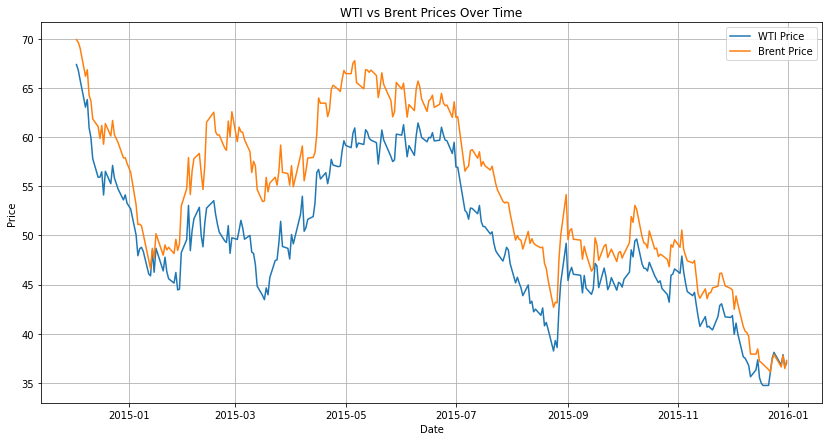

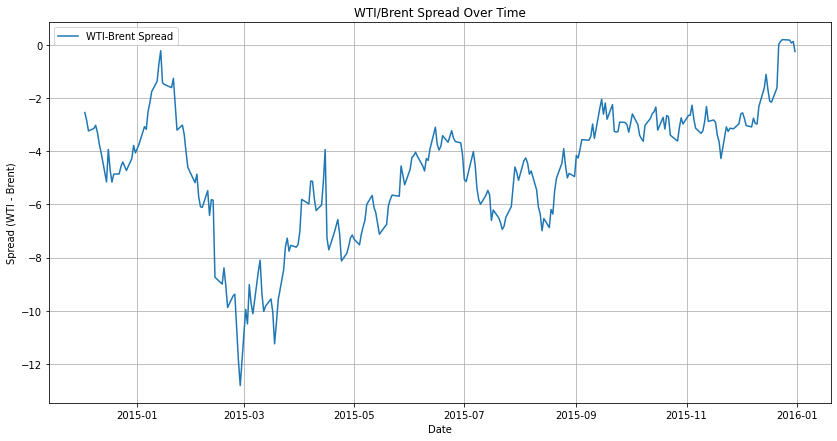

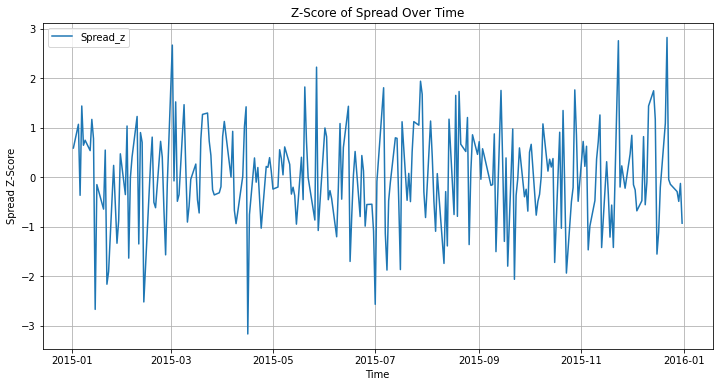

[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2014-12-03 to 2015-12-31): 0.0395%
Sharpe Ratio (Without Costs): -0.8989
Sharpe Ratio (With Costs): -0.9319
Calmar Ratio (Annualized): -6.924616723526149e-08
[*********************100%***********************]  1 of 1 completed
Information Ratio (Without Costs): -0.1944
Information Ratio (With Costs): -0.2002
Trading Metrics (Without Costs): {'Positive Trades': 12, 'Negative Trades': 19, 'Total Trades': 31, 'Max Drawdown ($)': 337690.0, 'Annual Return': -0.023383738213675453}
Trading Metrics (With Costs): {'Positive Trades': 12, 'Negative Trades': 19, 'Total Trades': 31, 'Max Drawdown ($)': 342711.19999999925, 'Annual Return': -0.024267910517277946}
----------------------------------------------------------------------------------------
2015-12-03 00:00:00  -  2016-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -3.902729765804794
p-value: 0.0020148491274252084
Critical Values:
   1%: -3.4547128138328875
   5%: -2.8722649771800155
   10%: -2.5724850011573914
The residuals are stationary. WTI and Brent prices are cointegrated.
[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2015-12-03 to 2016-12-31): 0.2933%


/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'].iloc[i] = daily_pnl  # Update PnL in the DataFrame
/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction_Costs'].iloc[i] = open_position['transaction_costs'] * 2


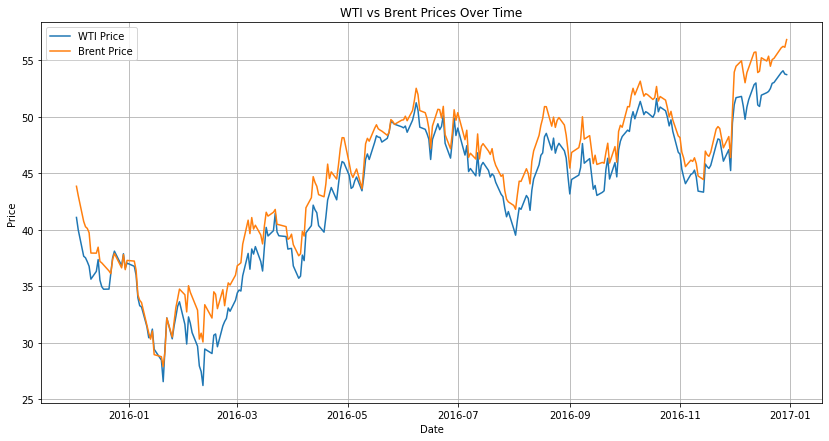

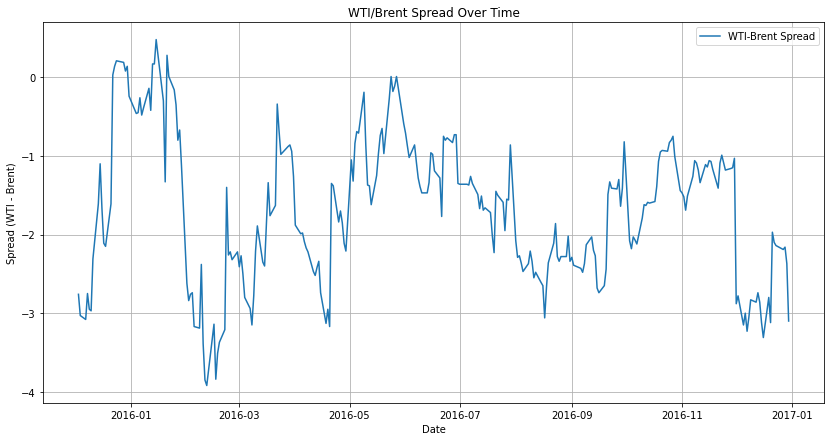

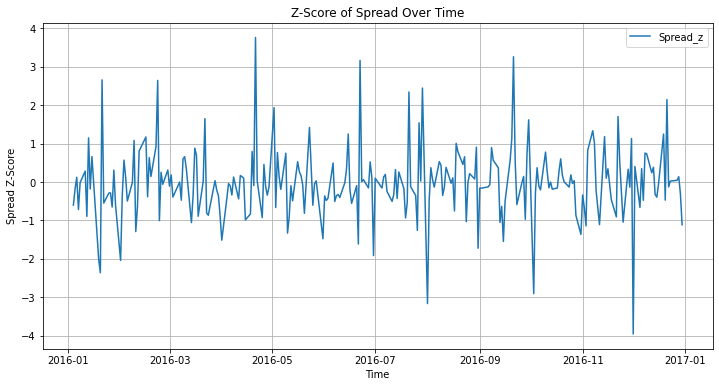

[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2015-12-03 to 2016-12-31): 0.2933%
Sharpe Ratio (Without Costs): 1.0875
Sharpe Ratio (With Costs): 1.0679
Calmar Ratio (Annualized): 2.1183485588816923e-07
[*********************100%***********************]  1 of 1 completed
Information Ratio (Without Costs): -0.3849
Information Ratio (With Costs): -0.3899
Trading Metrics (Without Costs): {'Positive Trades': 13, 'Negative Trades': 7, 'Total Trades': 20, 'Max Drawdown ($)': 182010.0, 'Annual Return': 0.03855606212020568}
Trading Metrics (With Costs): {'Positive Trades': 12, 'Negative Trades': 8, 'Total Trades': 20, 'Max Drawdown ($)': 182549.09999999963, 'Annual Return': 0.03786380976542714}
----------------------------------------------------------------------------------------
2016-12-03 00:00:00  -  2017-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -2.3648686934771708
p-value: 0.1518983932180586
Critical Values:
   1%: -3.4548957220044336
   5%: -2.8723451788613157
   10%: -2.572527778361272
The residuals are not stationary. WTI and Brent prices are not cointegrated.
----------------------------------------------------------------------------------------
2017-12-03 00:00:00  -  2018-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -1.3918375895346915
p-value: 0.5861829645758259
Critical Values:
   1%: -3.4550813975770827
   5%: -2.8724265892710914
   10%: -2.5725712007462582
The residuals are not stationary. WTI and Brent prices are not cointegrated.
----------------------------------------------------------------------------------------
2018-12-03 00:00:00  -  2019-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -1.7894534443743197
p-value: 0.3857101940484112
Critical Values:
   1%: -3.4548039258751206
   5%: -2.872304928618605
   10%: -2.5725063100137175
The residuals are not stationary. WTI and Brent prices are not cointegrated.
----------------------------------------------------------------------------------------
2019-12-03 00:00:00  -  2020-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -3.62830845202084
p-value: 0.005242330930849994
Critical Values:
   1%: -3.4550813975770827
   5%: -2.8724265892710914
   10%: -2.5725712007462582
The residuals are stationary. WTI and Brent prices are cointegrated.
[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2019-12-03 to 2020-12-31): 0.4229%


/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'].iloc[i] = daily_pnl  # Update PnL in the DataFrame
/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction_Costs'].iloc[i] = open_position['transaction_costs'] * 2


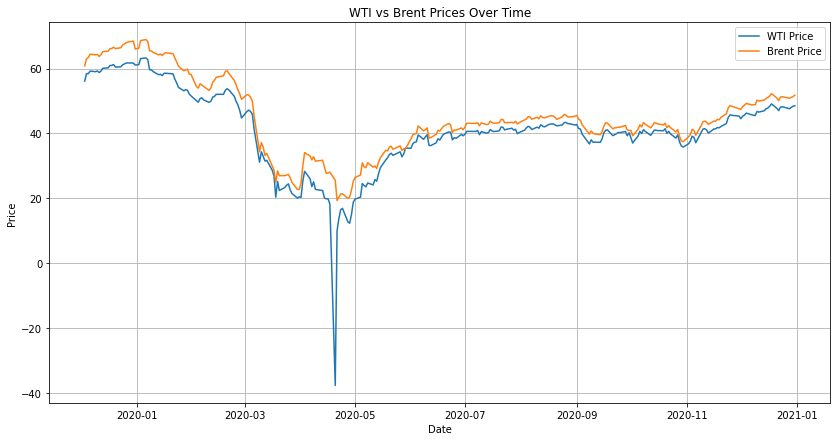

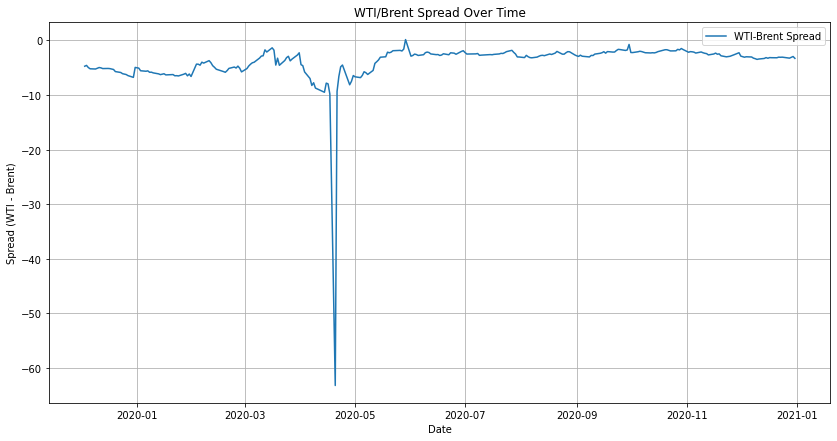

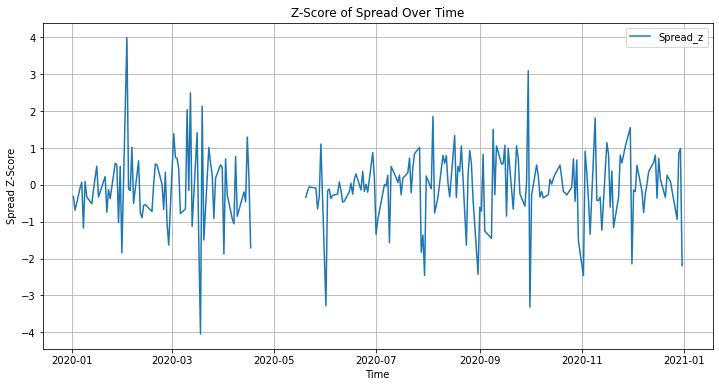

[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2019-12-03 to 2020-12-31): 0.4229%
Sharpe Ratio (Without Costs): 0.3209
Sharpe Ratio (With Costs): 0.3460
Calmar Ratio (Annualized): 5.303165104886631e-08
[*********************100%***********************]  1 of 1 completed
Information Ratio (Without Costs): 0.2581
Information Ratio (With Costs): 0.2841
Trading Metrics (Without Costs): {'Positive Trades': 32, 'Negative Trades': 12, 'Total Trades': 44, 'Max Drawdown ($)': 15690170.0, 'Annual Return': 0.8320756203373907}
Trading Metrics (With Costs): {'Positive Trades': 32, 'Negative Trades': 12, 'Total Trades': 44, 'Max Drawdown ($)': 15693284.900000002, 'Annual Return': 0.8295616409769448}
----------------------------------------------------------------------------------------
2020-12-03 00:00:00  -  2021-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -3.1594592866454634
p-value: 0.0224545666949734
Critical Values:
   1%: -3.4548039258751206
   5%: -2.872304928618605
   10%: -2.5725063100137175
The residuals are stationary. WTI and Brent prices are cointegrated.
[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2020-12-03 to 2021-12-31): 0.0375%


/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'].iloc[i] = daily_pnl  # Update PnL in the DataFrame
/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction_Costs'].iloc[i] = open_position['transaction_costs'] * 2


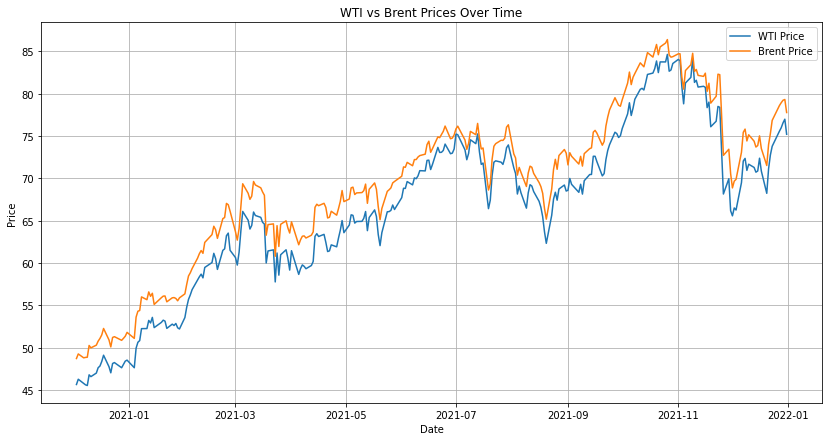

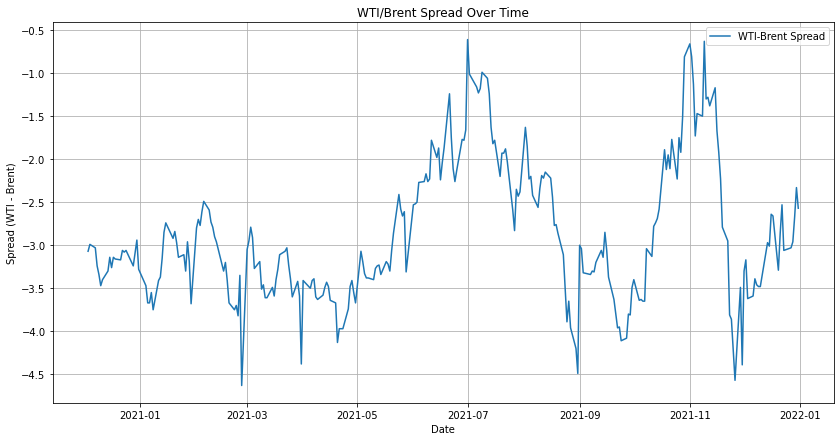

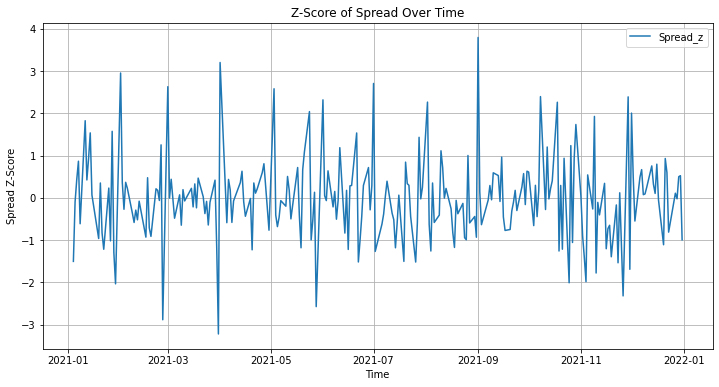

[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2020-12-03 to 2021-12-31): 0.0375%
Sharpe Ratio (Without Costs): 3.0316
Sharpe Ratio (With Costs): 3.0162
Calmar Ratio (Annualized): 3.867141502984203e-06
[*********************100%***********************]  1 of 1 completed
Information Ratio (Without Costs): -1.5065
Information Ratio (With Costs): -1.5105
Trading Metrics (Without Costs): {'Positive Trades': 18, 'Negative Trades': 7, 'Total Trades': 25, 'Max Drawdown ($)': 17320.0, 'Annual Return': 0.0669788908316864}
Trading Metrics (With Costs): {'Positive Trades': 18, 'Negative Trades': 7, 'Total Trades': 25, 'Max Drawdown ($)': 17539.799999998882, 'Annual Return': 0.06644138149738033}
----------------------------------------------------------------------------------------
2021-12-03 00:00:00  -  2022-12-31 00:00:00
----------------------------------------------------------------------------------------


/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engle-Granger Cointegration Test Results:
ADF Statistic: -3.564733577612107
p-value: 0.0064721623495140905
Critical Values:
   1%: -3.4548957220044336
   5%: -2.8723451788613157
   10%: -2.572527778361272
The residuals are stationary. WTI and Brent prices are cointegrated.
[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2021-12-03 to 2022-12-31): 1.8520%


/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'].iloc[i] = daily_pnl  # Update PnL in the DataFrame
/var/folders/2g/7lpyz7fd0_b15m4fm3mwbbd00000gn/T/ipykernel_93309/218439806.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction_Costs'].iloc[i] = open_position['transaction_costs'] * 2


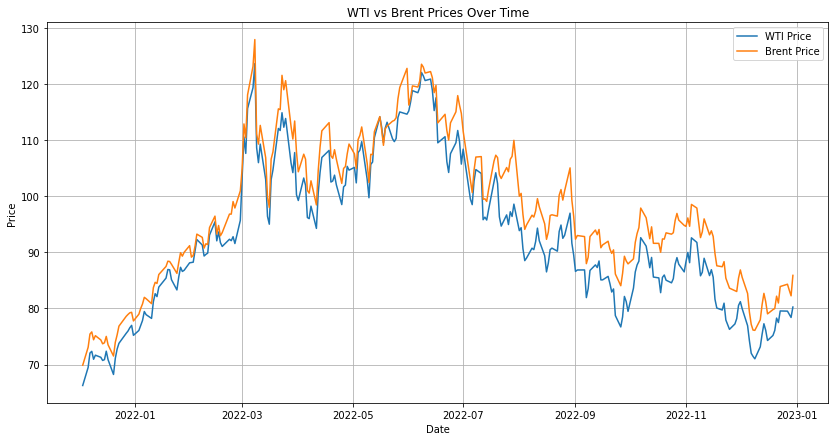

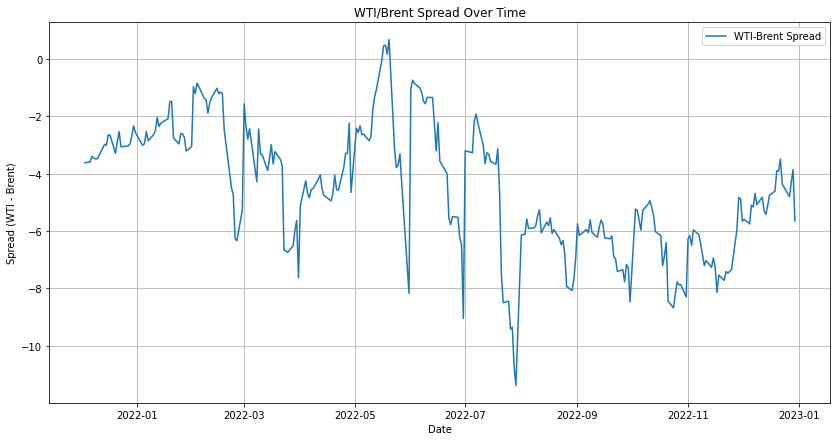

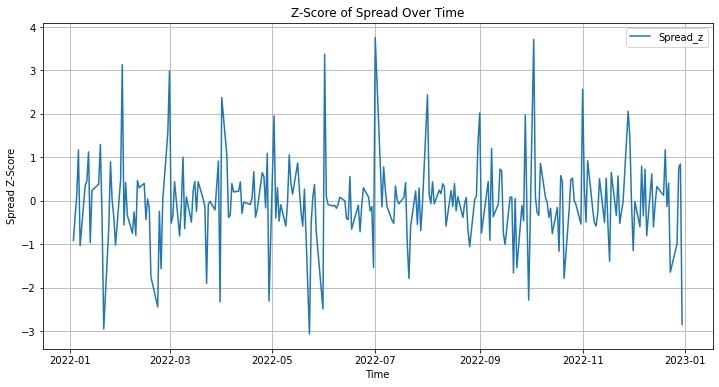

[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2021-12-03 to 2022-12-31): 1.8520%
Sharpe Ratio (Without Costs): -0.2247
Sharpe Ratio (With Costs): -0.2313
Calmar Ratio (Annualized): 6.527344811842617e-09
[*********************100%***********************]  1 of 1 completed
Information Ratio (Without Costs): 0.5547
Information Ratio (With Costs): 0.5531
Trading Metrics (Without Costs): {'Positive Trades': 8, 'Negative Trades': 17, 'Total Trades': 25, 'Max Drawdown ($)': 626729.9999999981, 'Annual Return': 0.004090882813926111}
Trading Metrics (With Costs): {'Positive Trades': 8, 'Negative Trades': 17, 'Total Trades': 25, 'Max Drawdown ($)': 627992.3999999985, 'Annual Return': 0.0037126498234056893}
----------------------------------------------------------------------------------------
2022-12-03 00:00:00  -  2023-12-31 00:00:00
----------------------------------------------------------------------------------------
Engle-Granger 

/Users/cameronwalcott/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
# start_date = dt.datetime(2015, 1, 1)
# end_date = dt.datetime(2015, 12, 31)
start_date = dt.datetime(2014, 12, 3)
end_date = dt.datetime(2015, 12, 31)
# Define the final end date for the loop
final_date = dt.datetime(2023, 12, 31)

# Loop to run the backtest, incrementing by a year
while end_date <= final_date:
    print('----------------------------------------------------------------------------------------')
    print(start_date, ' - ', end_date)
    print('----------------------------------------------------------------------------------------')
    t = backtest(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), 10000000)
    # Increment both start_date and end_date by 1 year
    start_date = start_date.replace(year=start_date.year + 1)
    end_date = end_date.replace(year=end_date.year + 1)
    


In [40]:
get_tbill_rate_yfinance('2023-01-01','2023-12-31')

[*********************100%***********************]  1 of 1 completed
Average 3-Month Treasury Bill Rate (2023-01-01 to 2023-12-31): 5.0452%


0.05045160009384155